# EE4375-2022: Extension of Fifth Lab Session: Assembly Using Map: Sequential and Distributed Version 

Solves the Poisson equation $- \frac{d^2 \, u(x)}{dx^2} = f(x)$ on the unit bar domain $x \in \Omega=(0,1)$ supplied with various boundary conditions and various source terms. The Galerkin finite element method is employed. This lab session complements the lectures with slides available at [shared drive](https://mega.nz/fm/CcsEnLxL). 

## Import Packages

In [1]:
using LinearAlgebra
using Plots
using LaTeXStrings
using SparseArrays
using BenchmarkTools 

## Section 1/: 1D Galerkin FEM Code Using for-loop over Elements
The code in this section is the classical approach of performing a for-loop over the elements. A dense (instead of sparse) matrix is allocated. This code is documented elsewhere in the course. 

To do: 
- convert from script to function;
- check type-stability and runtime of the function; 

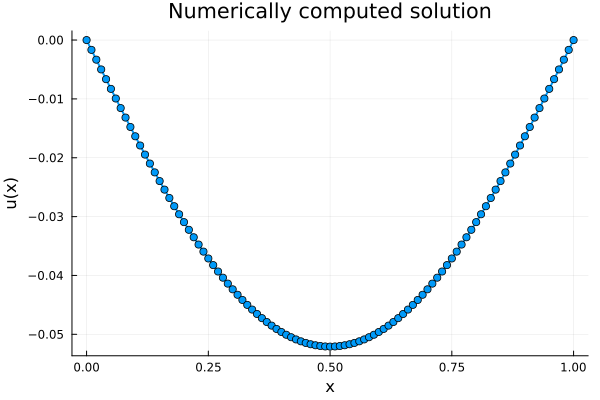

In [2]:
#..construct the mesh: generated uniform mesh with N elements   
N = 100; h = 1/N; 
x = Vector(0:h:1); 

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
#..use comprehension to build both lists
points = [ [x[i], x[i+1]] for i in 1:N]
edges =  [ [i, i+1] for i in 1:N]; 

#..Set the source function 
fsource(x) = x*(x-1); 

#..Initialize global matrix and right-hand side value 
A = zeros(N+1, N+1); 
f = zeros(N+1); 

#..Perform loop over elements and assemble global matrix and vector 
for i=1:N  

  xl, xr = points[i]
  floc = (xr-xl) * [fsource(xl) ; fsource(xr)];
  Aloc = (1/(xr-xl))*[1 -1; -1 1]; 

  f[edges[i]] += floc;
  A[edges[i], edges[i]] += Aloc;

end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;     A[1,2] = 0;        f[1]   = 0; 
A[end,end-1]=0; A[end,end] = 1;    f[end] = 0;

#..solve the linear system
u = A \ f; 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

In [86]:
xl, xr = points[2]

2-element Vector{Float64}:
 0.01
 0.02

## Section 2:/ Using map over the List of Elements 
In this section we illustrate the concept of map over a list.

To do:
- replace map() by lazy_map() 

### Section 1.2:/ Use of map of a function over list of values
Here we illustrate the concept of map over a list for a function with a single output (or return value).  

In [5]:
function times_two(x)
    return 2*x
end 

input = [1., 2., 3.]

output = map(times_two,input);

@show output

output = [2.0, 4.0, 6.0]


3-element Vector{Float64}:
 2.0
 4.0
 6.0

### Section 2.2:/ Use of map of a function with multiple outputs over a list of values
Here we illustrate the concept of splatting (denoted by ...) to treat functions with multiple outputs. 

In [8]:
function times_two_times_three(x)
    return 2*x, 3*x
end 

input = [1., 2., 3.]

output = map(times_two_times_three,input)

@show output

doubles, triplets = vcat.(output...)

@show doubles
@show triplets

output = [(2.0, 3.0), (4.0, 6.0), (6.0, 9.0)]
doubles = [2.0, 4.0, 6.0]
triplets = [3.0, 6.0, 9.0]


3-element Vector{Float64}:
 3.0
 6.0
 9.0

### Section 2.3:/ Use of map of a function typical for FEM assembly 
Here we illustrate the use of map for a function similar to FEM assembly.   

In [9]:
ff(x) = [1;1]
gg(x) = x*[1;1]
hh(x) = [1;1], x*[1;1]
fff = mapreduce(ff,vcat, [1 2 3])
ggg = mapreduce(gg,vcat, [1 2 3])
ggg1 = map(gg,[1 2 3])
hhh = map(hh, [1 2 3])
@show fff 
@show ggg
@show ggg1
@show hhh 

fff = [1, 1, 1, 1, 1, 1]
ggg = [1, 1, 2, 2, 3, 3]
ggg1 = [[1, 1] [2, 2] [3, 3]]
hhh = [([1, 1], [1, 1]) ([1, 1], [2, 2]) ([1, 1], [3, 3])]


1×3 Matrix{Tuple{Vector{Int64}, Vector{Int64}}}:
 ([1, 1], [1, 1])  ([1, 1], [2, 2])  ([1, 1], [3, 3])

## Section 3:/ FEM Assembly using map over elements 

### Section 1.3:/ Compute Area of Elements 
Here we use map to compute the area of the elements. The replacement of map by lazy_map is left for future extensions. 

In [122]:
#..construct the mesh: see before 
N = 3; h = 1/N; 
x = Vector(0:h:1); 

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
#..use comprehension to build both lists
points = [[x[i], x[i+1]] for i in 1:N] 
edges =  [[i, i+1] for i in 1:N] 

#..function to compute local matrix contributions.. 
function compute_elem_area(elem_id, p, e)
  xl, xr = points[elem_id] 
  area = xr - xl 
  return area
end

#..map over all elements to assemble A and f 
map(elem_id -> compute_elem_area(elem_id,p,e), Vector(1:length(edges)))

3-element Vector{Float64}:
 0.3333333333333333
 0.3333333333333333
 0.33333333333333337

### Section 2.3:/ Using a dense matrix 
This version adds to global vector and matrix at each iteration of map. 

Future work: in this version the anonymous function can be replaced by a map-do construction. 

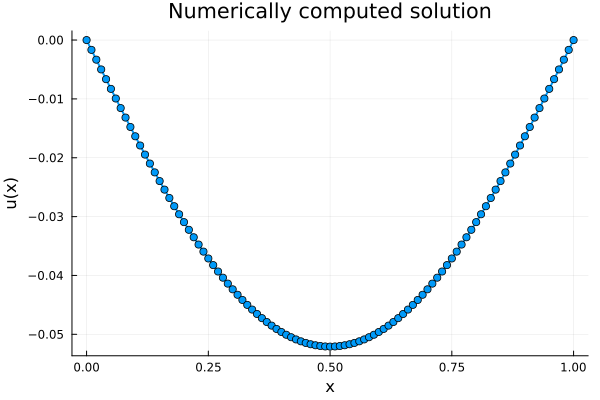

In [90]:
#..construct the mesh: see before 
N = 100; h = 1/N; 
x = Vector(0:h:1); 

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
#..use comprehension to build both lists
points = [[x[i], x[i+1]] for i in 1:N] 
edges =  [[i, i+1] for i in 1:N] 

#..Set the source function 
fsource(x) = x*(x-1); 

#..Initialize global matrix and right-hand side value 
A = zeros(Np1,Np1); 
f = zeros(Np1); 

#..compute on one element and add to vector and matrix 
function compose_A_and_f!(A, f, elem_id)
  xl, xr = points[elem_id]
  floc = (xr-xl) * [fsource(xl) ; fsource(xr)]
  Aloc = (1/(xr-xl))*[1 -1; -1 1]

  f[edges[elem_id]] += floc
  A[edges[elem_id], edges[elem_id]] += Aloc
end 

#..map over all elements to assemble A and f 
map(elem_id -> compose_A_and_f!(A, f, elem_id), Vector(1:length(edges)))

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;     A[1,2] = 0;        f[1]   = 0; 
A[end,end-1]=0; A[end,end] = 1;    f[end] = 0;

#..solve the linear system
u = A \ f; 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

### Section 3.3:/ Using Sparse Matrix  

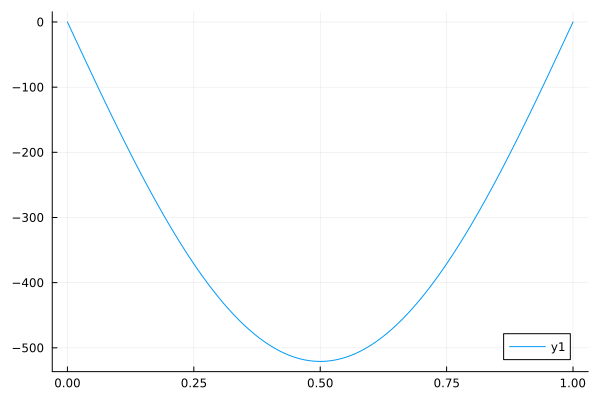

In [136]:
#..Intermediate solution.. 
#..construct the mesh
N = 100; h = 1/N; 
x = Vector(0:h:1); 

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
#..use comprehension to build both lists
points = [[x[i], x[i+1]] for i in 1:N] 
edges =  [[i, i+1] for i in 1:N] 

#..Set the source function 
fsource(x) = x*(x-1); 

#..function to compute local matrix contributions.. 
function compute_elem_mat(elem_id, p, e)
  xl, xr = points[elem_id] 
  area  = xr - xl 
  elemI = [ e[elem_id][1] e[elem_id][1] e[elem_id][2] e[elem_id][2] ] 
  elemJ = [ e[elem_id][1] e[elem_id][2] e[elem_id][1] e[elem_id][2] ]
  elemA = area*[1 -1 -1 1]
  return elemI, elemJ, elemA 
end

#..function to compute local vector contributions.. 
function compute_elem_vec(elem_id, p, e)
  xl, xr = points[elem_id] 
  area  = xr - xl 
  elemI = [e[elem_id][1] e[elem_id][2]] 
  elemf = area* [fsource(xl) fsource(xr)]
  return elemI, elemf 
end

#..list of all element numbers 
elem_ids = Vector(1:N)

#..assemble list of elementary matrix contributions 
tt = map(elem_ids) do elem_id 
    compute_elem_mat(elem_id, points, edges)
end

#..seperate arguments in the list using splatting 
I, J, vals = vcat.(tt...)

#..assembly sparse matrix 
A = sparse(I[:],J[:],vals[:])

#..assemble list of elementary matrix contributions 
tt = map(elem_ids) do elem_id 
    compute_elem_vec(elem_id, points, edges)
end

#..seperate arguments in the list using splatting 
I, vals = vcat.(tt...)

#..assembly vector  
f = sparsevec(I[:],vals[:])
f = Vector(f)

#..need to take care of so-called splashing 
A[1,1] = 1;      A[1,2] = 0;        f[1]     = 0; 
A[end,end-1]=0;  A[end,end] = 1;    f[end] = 0;

#..solve the linear system
u = A \ f; 

#..plot the solution  
plot(x,u)

## Section 4:/ Distributed Memory Distribution  

In [124]:
using PartitionedArrays

In [156]:
#..generate partition of the list of elements 
np = 1 # number of partitions 
N = 8 # number of elements in the mesh 
ranks = LinearIndices((np,))
elem_partition = uniform_partition(ranks,N);
@show ranks 
@show elem_partition

ranks = [1]
elem_partition = PartitionedArrays.LocalIndicesWithConstantBlockSize{1}[[1, 2, 3, 4, 5, 6, 7, 8]]


1-element Vector{PartitionedArrays.LocalIndicesWithConstantBlockSize{1}}:
 [1, 2, 3, 4, 5, 6, 7, 8]

In [157]:
h = 1/N; 
x = Vector(0:h:1); 

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
#..use comprehension to build both lists
points = [[x[i], x[i+1]] for i in 1:N] 
edges =  [[i, i+1] for i in 1:N] 

#..function to compute local matrix contributions.. 
function compute_elem_mat(elem_id, p, e)
  xl, xr = points[elem_id] 
  area  = xr - xl 
  elemI = [ e[elem_id][1] e[elem_id][1] e[elem_id][2] e[elem_id][2] ] 
  elemJ = [ e[elem_id][1] e[elem_id][2] e[elem_id][1] e[elem_id][2] ]
  elemA = area*[1 -1 -1 1]
  return elemI, elemJ, elemA 
end

#..loop over element in the partition or every subdomain  
IJV = map(elem_partition) do elem_subdomain 
    #..initialize 
    I, J, V = Vector{Int}(), Vector{Int}(), Vector{Float64}()
    #..loop over element in the subdomain   
    tt_subdomain = map(elem_subdomain) do elem_id
        compute_elem_mat(elem_id, points, edges)
    end 
    #..seperate arguments in the list using splatting 
    I_subdomain, J_subdomain, V_subdomain = vcat.(tt_subdomain...)
    #..add to global list     
    append!(I, I_subdomain[:][1:end])
    append!(J, J_subdomain[:][1:end])
    append!(V, V_subdomain[:][1:end])
    I,J,V 
end

#@show IJV 

I,J,V = vcat.(IJV...)
@show I 
@show J 
@show V 

I = [1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9]
J = [1, 2, 3, 4, 5, 6, 7, 8, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 2, 3, 4, 5, 6, 7, 8, 9]
V = [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]


32-element Vector{Float64}:
  0.125
  0.125
  0.125
  0.125
  0.125
  0.125
  0.125
  0.125
 -0.125
 -0.125
 -0.125
 -0.125
 -0.125
  ⋮
 -0.125
 -0.125
 -0.125
 -0.125
  0.125
  0.125
  0.125
  0.125
  0.125
  0.125
  0.125
  0.125

In [150]:
?push!

search: push! pushfirst! pushdisplay



```
push!(collection, items...) -> collection
```

Insert one or more `items` in `collection`. If `collection` is an ordered container, the items are inserted at the end (in the given order).

# Examples

```jldoctest
julia> push!([1, 2, 3], 4, 5, 6)
6-element Vector{Int64}:
 1
 2
 3
 4
 5
 6
```

If `collection` is ordered, use [`append!`](@ref) to add all the elements of another collection to it. The result of the preceding example is equivalent to `append!([1, 2, 3], [4, 5, 6])`. For `AbstractSet` objects, [`union!`](@ref) can be used instead.

See [`sizehint!`](@ref) for notes about the performance model.

See also [`pushfirst!`](@ref).

---

```
push!(q::Deque{T}, x)
```

Add an element to the back

---

```
push!(s::IntDisjointSets{T})
```

Make a new subset with an automatically chosen new element x. Returns the new element. Throw an `ArgumentError` if the capacity of the set would be exceeded.

---

```
push!(s::DisjointSets{T}, x::T)
```

Make a new subset with an automatically chosen new element x. Returns the new element.

---

```
push!(h::BinaryHeap, value)
```

Adds the `value` element to the heap `h`.

---

```
push!(sc, k=>v)
```

Argument `sc` is a SortedDict or SortedMultiDict and `k=>v` is a key-value pair. This inserts the key-value pair into the container. If the key is already present, this overwrites the old value. The return value is `sc`. Time: O(*c* log *n*)

---

```
push!(sc, k=>v)
```

Argument `sc` is a SortedDict or SortedMultiDict and `k=>v` is a key-value pair. This inserts the key-value pair into the container. If the key is already present, this overwrites the old value. The return value is `sc`. Time: O(*c* log *n*)

---

```
push!(sc, k)
```

Argument `sc` is a SortedSet and `k` is a key. This inserts the key into the container. If the key is already present, this overwrites the old value. (This is not necessarily a no-op; see below for remarks about the customizing the sort order.) The return value is `sc`. Time: O(*c* log *n*)

---

```
push!(cb::CircularBuffer, data)
```

Add an element to the back and overwrite front if full.

---

```
push!(tree, key)
```

Inserts `key` in the `tree` if it is not present.

---

```
push!(ch, key, val)
```

Push contents of `val` to collection associated with `key` in `ch::ConvergenceHistory`.
